In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## 1. Загрузка и первичный осмотр данных

In [2]:
df = pd.read_csv('Mobile Price Prediction.csv')
df.sample(5)

,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
20,289,2438,21,162.0,5.3,277,8,1.5,32.0,4.0,13.0,8.0,4000,7.7
127,1112,2491,455,753.0,12.2,247,8,1.6,32.0,3.0,8.0,2.0,9500,8.0
5,947,2137,12,150.0,5.5,401,4,2.3,16.0,2.0,16.0,8.0,2500,9.5
138,377,2409,1009,160.0,5.0,441,4,2.3,32.0,2.0,4.0,5.0,2600,9.4
100,1080,2343,198,158.0,5.1,432,4,2.5,16.0,2.0,16.0,2.0,2800,8.9


In [3]:
#смотрим общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product_id    161 non-null    int64  
 1   Price         161 non-null    int64  
 2   Sale          161 non-null    int64  
 3   weight        161 non-null    float64
 4   resoloution   161 non-null    float64
 5   ppi           161 non-null    int64  
 6   cpu core      161 non-null    int64  
 7   cpu freq      161 non-null    float64
 8   internal mem  161 non-null    float64
 9   ram           161 non-null    float64
 10  RearCam       161 non-null    float64
 11  Front_Cam     161 non-null    float64
 12  battery       161 non-null    int64  
 13  thickness     161 non-null    float64
dtypes: float64(8), int64(6)
memory usage: 17.7 KB


In [4]:
df.shape

(161, 14)

In [5]:
#смотрим пропуски в значениях
df.isna().sum()

Product_id      0
Price           0
Sale            0
weight          0
resoloution     0
ppi             0
cpu core        0
cpu freq        0
internal mem    0
ram             0
RearCam         0
Front_Cam       0
battery         0
thickness       0
dtype: int64

In [6]:
#смотрим наличие явных дубликатов
df.duplicated().sum()

0

Выводы после первичного осмотра (этапы 1–2):

Размер и структура:
- 161 наблюдение, 14 признаков.
- Пропусков нет – данные заполнены полностью.
- Явные дубликаты отсутствуют

Типы признаков:
- 6 столбцов int64, 8 – float64.

Предобработка:
- Категориальных переменных нет – не потребуется one-hot кодирование.
- Разброс величин у признаков разный (например, resolution и battery в сотнях/тысячах, thickness в единицах), значит понадобится масштабирование (StandardScaler или аналог).??????????

Столбцы имеют разные названия, заменим на один формат

In [7]:
df.columns = df.columns.str.title().str.replace(' ', '_')
df.columns

Index(['Product_Id', 'Price', 'Sale', 'Weight', 'Resoloution', 'Ppi',
       'Cpu_Core', 'Cpu_Freq', 'Internal_Mem', 'Ram', 'Rearcam', 'Front_Cam',
       'Battery', 'Thickness'],
      dtype='object')

In [8]:
#описательные статистики
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Product_Id,161.0,675.559006,410.851583,10.0,237.0,774.00,1026.000,1339.0
Price,161.0,2215.596273,768.187171,614.0,1734.0,2258.00,2744.000,4361.0
Sale,161.0,621.465839,1546.618517,10.0,37.0,106.00,382.000,9807.0
Weight,161.0,170.426087,92.888612,66.0,134.1,153.00,170.000,753.0
Resoloution,161.0,5.209938,1.509953,1.4,4.8,5.15,5.500,12.2
Ppi,161.0,335.055901,134.826659,121.0,233.0,294.00,428.000,806.0
Cpu_Core,161.0,4.857143,2.444016,0.0,4.0,4.00,8.000,8.0
Cpu_Freq,161.0,1.502832,0.599783,0.0,1.2,1.40,1.875,2.7
Internal_Mem,161.0,24.501714,28.804773,0.0,8.0,16.00,32.000,128.0
Ram,161.0,2.204994,1.609831,0.0,1.0,2.00,3.000,6.0


Признаки имеют очень разную вариативность: некоторые (например, Sale, battery) сильно скошены вправо, другие (weight, thickness) — относительно узкие.

Нулевые значения в CPU, памяти и камерах указывают на отсутствующие модули или некорректные записи.

Широкие диапазоны значений обосновывают обязательное масштабирование перед моделированием.

Целевая метрика Price распределена более равномерно, тогда как Sale нуждается в дополнительной трансформации или особом учёте при выборе модели.

## EDA-анализ

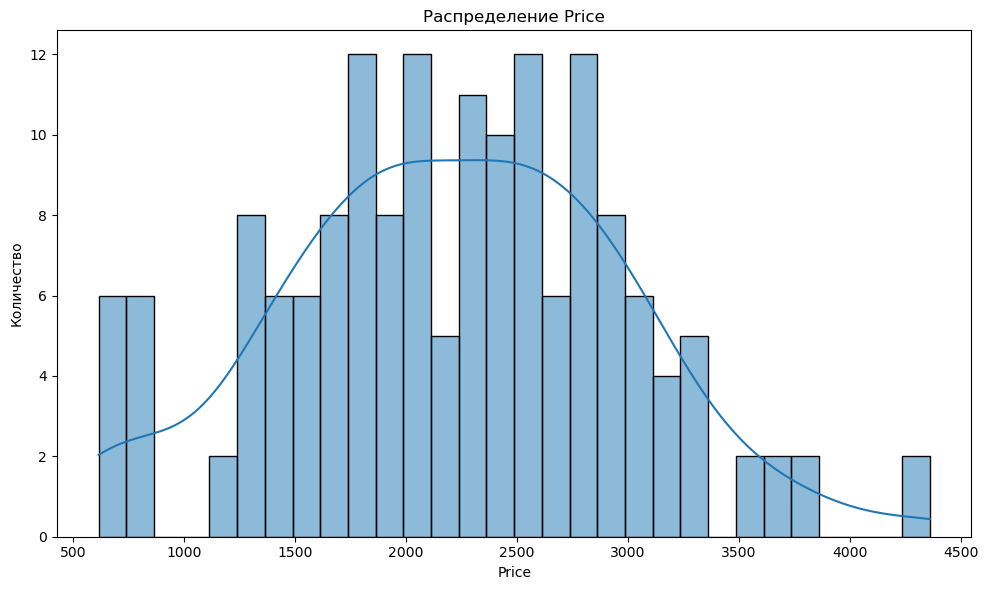

In [9]:
#распределение целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Распределение Price')
plt.xlabel('Price')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

- Распределение Price является унемодальным с пиком примерно на уровне 2000–2500, где сосредоточено большинство устройств.
- Имеются редкие «хвосты» в область очень дешёвых (< 800) и очень дорогих (> 3500) моделей, но они мало влияют на общую форму.
- Форма почти симметричная, лишь небольшой правый «хвост»
- Явных сильных скошенностей нет, поэтому для регрессии можно работать с оригинальным признаком без лог-трансформации. значения.


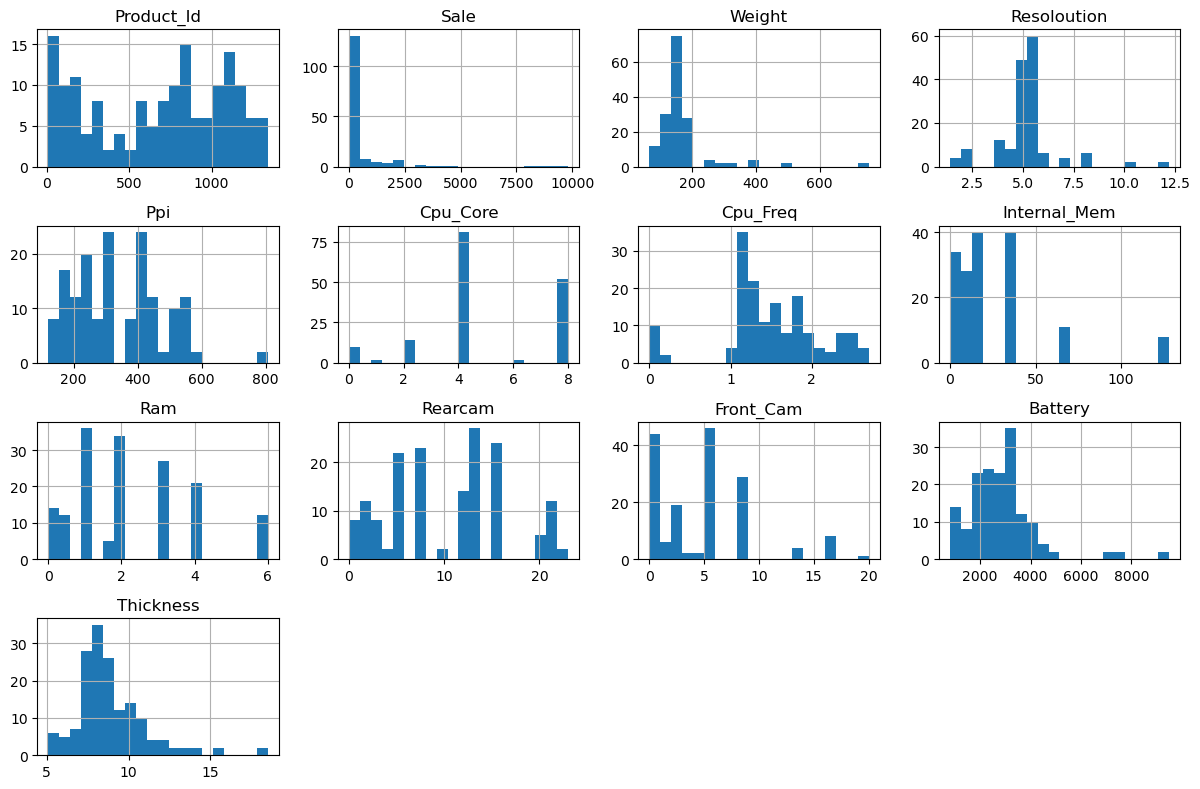

In [10]:
#Гистограммы всех признаков
df.drop(columns=['Price']).hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

- Weight: почти нормальное распределение вокруг 150–200 г, редкие тяжёлые (> 400 г) смартфоны  
- Resolution: большинство камер около 5 Мп, небольшой «хвост» к 10–12 Мп  
- PPI: мультимодальное распределение с пиками около 300–400 ppi и единичными моделями с очень высоким значением  
- CPU_Core: чёткие столбцы на 0, 4 и 8 ядер (0 означает отсутствие или неуказанный модуль)  
- CPU_Freq: концентрация в диапазоне 1–2 ГГц, редкие более мощные процессоры  
- Internal_Mem: пики на 0, 8, 16 и 32 ГБ, единичные устройства с большим объёмом памяти  
- Ram: дискретные значения 0, 1, 2, 3 и 6 ГБ  
- Rear_Cam: ступенчатые значения на 0, 5, 8, 12, 16 и 20+ Мп  
- Front_Cam: ступенчатые значения на 0, 5, 8, 12, 16 и 20+ Мп  
- Battery: сильная правая скошенность — большинство 2000–4000 мА·ч, несколько «монстров» > 6000 мА·ч  
- Thickness: сосредоточено вокруг 7–10 мм, редкие «толстые» модели > 12 мм  
- Sale: выраженная правая скошенность — большинство продаж низкие (< 200), единичные хит до 9800  


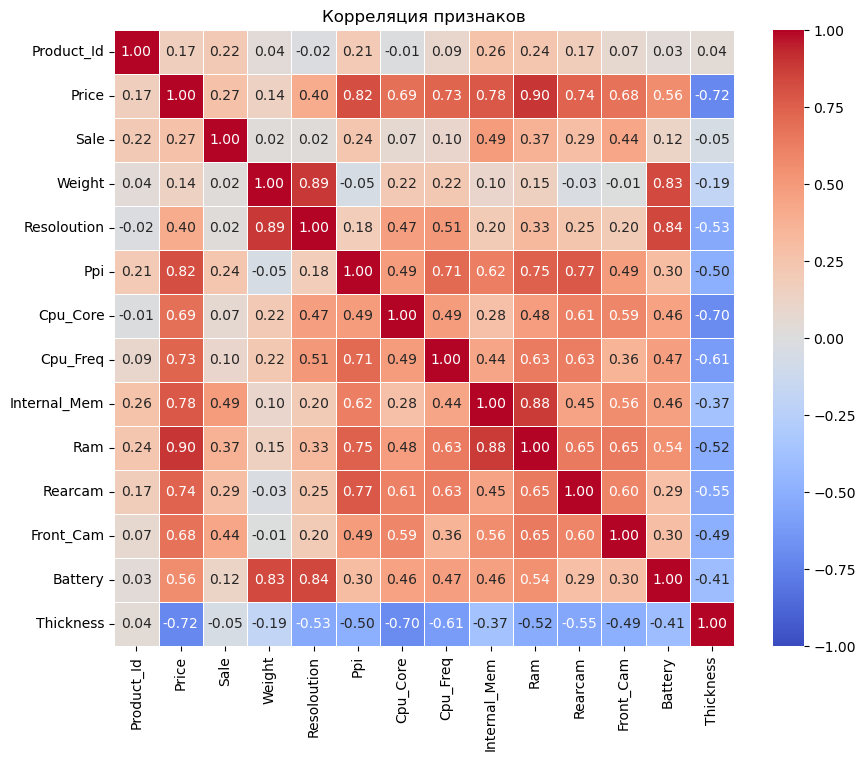

In [11]:
#корреляционная теплокарта
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Корреляция признаков')
plt.show()

Исходя из корреляционной матрицы, мы видим, что некоторые признаки избыточны и крайне сильно связаны друг с другом (например, PPI ≈ Resolution и RAM ≈ Internal\_Mem), а другие (Thickness) демонстрируют обратную связь с ценой. Чтобы избежать мультиколлинеарности и улучшить устойчивость моделей, удалим дублирующие признаки, преобразуем скошенные распределения и удалим служебный столбец Product_Id. Затем приведём все оставшиеся числовые колонки к единой шкале с помощью StandardScaler и подготовим данные к обучению.

In [12]:
#удаляем служебный столбец
df = df.drop(columns=['Product_Id'])

#удаляем Resoloution (дублирует Weight), Internal_Mem (дублирует Ram).
df = df.drop(columns=['Resoloution', 'Internal_Mem'])

#преобразуем скошенные распределения через логарифм
df['Sale_log']    = np.log1p(df['Sale'])
df['Battery_log'] = np.log1p(df['Battery'])

df.sample(5)

,Price,Sale,Weight,Ppi,Cpu_Core,Cpu_Freq,Ram,Rearcam,Front_Cam,Battery,Thickness,Sale_log,Battery_log
149,614,2159,69.8,129,0,0.00,0.004,0.00,0.0,800,14.1,7.677864,6.685861
80,2714,106,156.0,401,8,1.35,2.000,13.00,5.0,2300,5.1,4.672829,7.741099
47,3316,41,144.0,428,8,1.75,3.000,20.70,5.1,2930,6.9,3.737670,7.983099
3,1315,11,118.5,233,2,1.30,0.512,3.15,0.0,1400,11.0,2.484907,7.244942
141,628,1274,102.9,128,0,0.00,0.128,1.30,0.0,950,18.5,7.150701,6.857514


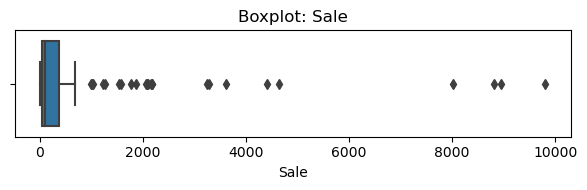

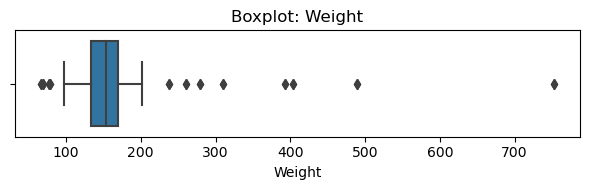

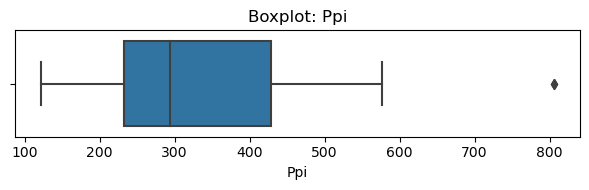

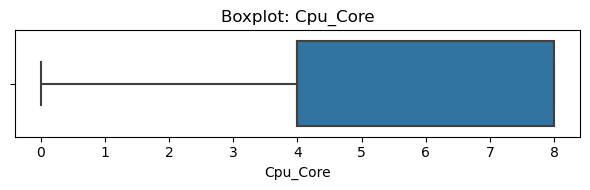

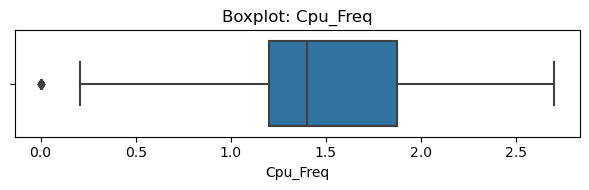

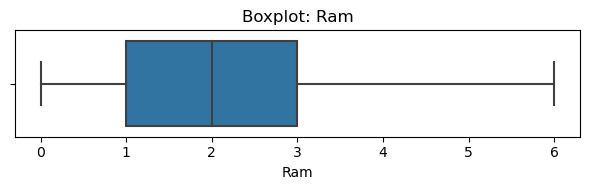

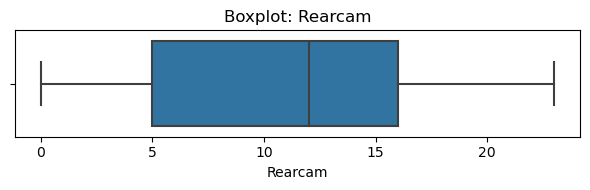

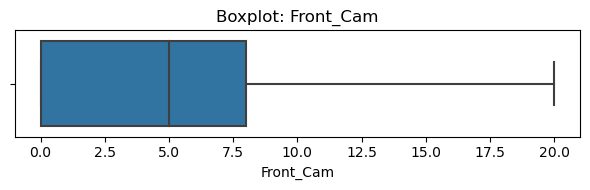

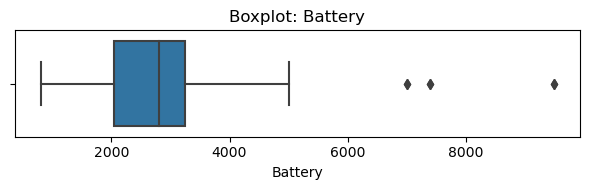

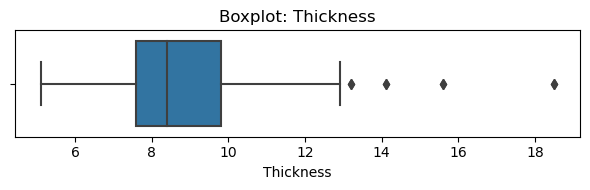

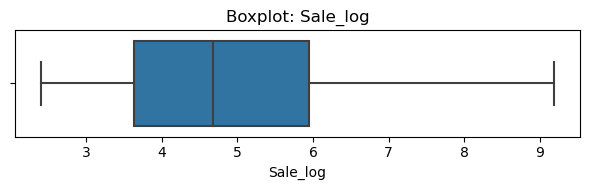

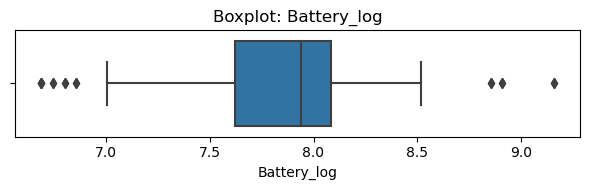

In [13]:
for col in df.columns.drop('Price'):
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()
    plt.show()


На основе боксплотов делаем следующие выводы:

Удаляем выбросы в Sale:
- У нас есть несколько экстремальных значений, которые явно выбиваются из общего распределения. Очевидно, что эти значения представляют собой редкие случаи, и их стоит удалить.

Удаляем выбросы в Weight:
- Здесь тоже есть несколько значений, превышающих 400–500, что вряд ли характерно для большинства смартфонов. Удаляем.

Оставляем PPI:
- Выбросов не так много, они не критичны для анализа, можно оставить.

Оставляем CPU_Core, CPU_Freq, Ram:
- Никаких ярко выраженных выбросов, эти признаки логично ограничены в своих значениях.

Удаляем выбросы в Battery:
- Значения выше 6000 мА·ч слишком выбиваются и явно являются выбросами.

Оставляем Thickness:
- Пара выбросов, но не критичных для анализа. Оставляем.

In [14]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df[
    (df['Sale'] >= lower_bound['Sale']) & (df['Sale'] <= upper_bound['Sale']) &
    (df['Weight'] >= lower_bound['Weight']) & (df['Weight'] <= upper_bound['Weight']) &
    (df['Battery'] >= lower_bound['Battery']) & (df['Battery'] <= upper_bound['Battery'])
]

print(f"Размер данных после удаления выбросов: {df_cleaned.shape}")

Размер данных после удаления выбросов: (117, 13)


## 3. Построение моделей

**Разделяем данные для обучения моделей**

In [21]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Price'])
y = df['Price']

#разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер train: {X_train.shape}, test: {X_test.shape}")

Размер train: (128, 12), test: (33, 12)


Применим следующие модели для предсказания цены (регрессия):

1. Линейная регрессия (где будет использоваться градиентный спуск)

2. Дерево решений

3. Метод k ближайших соседей (KNN)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [27]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'KNN': KNeighborsRegressor()
}

results = {}

#бучение моделей и оценка
for name, model in models.items():
    #создаем пайплайн с масштабированием и моделью
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', model) 
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    results[name] = {'MSE': mse, 'RMSE': rmse}

for model_name, metrics in results.items():
    print(f"{model_name}: MSE = {metrics['MSE']:.4f}, RMSE = {metrics['RMSE']:.4f}")


Linear Regression: MSE = 33516.5877, RMSE = 183.0754
Decision Tree: MSE = 31213.6667, RMSE = 176.6739
KNN: MSE = 56050.4048, RMSE = 236.7497


**После сравнения моделей с использованием метрик MSE и RMSE, можно сделать следующие выводы:**

1. Линейная регрессия показала результаты с MSE равным 33516.59 и RMSE 183.08. Несмотря на то, что линейная регрессия достаточно проста и часто используется как базовая модель, её производительность в данном случае не является оптимальной, поскольку ошибка значительная.

2. Дерево решений дало лучшие результаты, с MSE 31213.67 и RMSE 176.67. Это подтверждает, что дерево решений лучше подходит для данного набора данных, так как оно может выявить нелинейные зависимости, которые линейная регрессия не способна захватить.

3. Метод k ближайших соседей (KNN) продемонстрировал наихудшие результаты с MSE 56050.40 и RMSE 236.75. Этот метод, вероятно, страдает от высоких вычислительных затрат и переобучения, что особенно заметно на данных с высокой вариативностью и сложными зависимостями.

В итоге, дерево решений является наиболее эффективной моделью для данной задачи, так как оно минимизирует ошибку по сравнению с другими методами.